In [1]:
from importlib import reload
import numpy as np
import folium
import src.localization as localization
reload(localization)
from src.localization import read_data
from src.localization import plot_coeffs
from src.localization import get_distance_in_meters
from src.localization import gen_regressors
from src.localization import gen_fingerprints
from src.localization import cell_search

1) Read Data
==

In [2]:
positions, df_points = read_data('resources/data/LocTreino_Equipe_2.csv')

In [3]:
bts_positions, df_btss = read_data('resources/data/dados_BTSs.csv')

## 1.1) Plot Original Points


In [4]:
# Calculate map center
center_lat = np.mean([lat for lat in bts_positions[:, 0]])
center_lon = np.mean([lon for lon in bts_positions[:, 1]])
original_pts_map = folium.Map(location=[center_lat, center_lon],
                              zoom_start=15,
                              tiles='CartoDB dark_matter')

In [5]:
# Plot points
for location in positions:
    marker = folium.CircleMarker(location=location,
                                 radius=1,
                                 color='blue',
                                 fill_opacity=0.1)
    marker.add_to(original_pts_map)

# Plot BTSs locations
for location in bts_positions:
    marker = folium.Marker(location=location)
    marker.add_to(original_pts_map)

# Export map
original_pts_map.save("resources/maps/original_pts_map.html")

In [6]:
# Show map
original_pts_map

## Fit Linear Model

In [7]:
from sklearn import linear_model

# Choose columns to keep in X 
# (remove unimportant/target columns)
columns = [c for c in df_points.columns if c not in ['pontoId',
                                                     'lat',
                                                     'lon']]

# X
samples = df_points[columns].values

# Latitude regressor
# Y_lat
target_lat = df_points['lat'].values
lat_reg = linear_model.LinearRegression(normalize=True)
lat_reg.fit(samples, target_lat)

# Longitude regressor
# Y_lon
target_lon = df_points['lon'].values
lon_reg = linear_model.LinearRegression(normalize=True)
lon_reg.fit(samples, target_lon)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

### Weight distribuition (latitude)

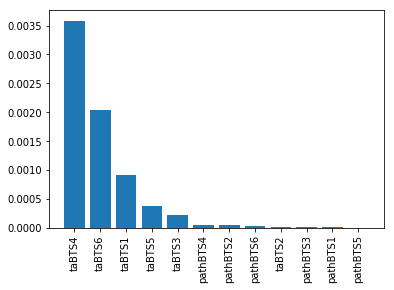

In [8]:
plot_coeffs(lat_reg, df_points.columns[3:])

### Weight distribution (longitude)

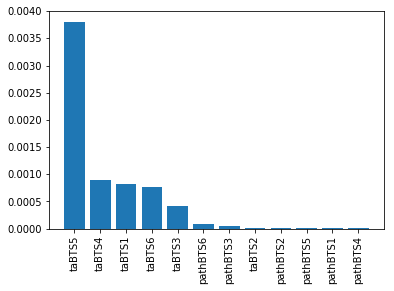

In [9]:
plot_coeffs(lon_reg, df_points.columns[3:])

### Calculate Errors

In [10]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

def rmse(y_pred, y_real):
    return sqrt(mse(y_pred, y_real))

# Predict
predicted_lat = lat_reg.predict(samples)
predicted_lon = lon_reg.predict(samples)

# Calculate error
lat_err = rmse(predicted_lat, target_lat)
lon_err = rmse(predicted_lon, target_lon)
print('Latitude RMSE (meters):', get_distance_in_meters(0, 0, lat_err, 0))
print('Longitude RMSE (meters):', get_distance_in_meters(0, 0, 0, lon_err))

Latitude RMSE (meters): 146.8028601591637
Longitude RMSE (meters): 184.98274926430946


### Generate error map (testing with the same training points)

In [11]:
result_map = folium.Map(location=[center_lat, center_lon],
                        zoom_start=13,
                        tiles='CartoDB dark_matter')
n_points = 10000
predicted_positions = list(zip(predicted_lat, predicted_lon))
for location in predicted_positions:
    marker = folium.CircleMarker(location=location, color='red', weight=1, radius=3)
    marker.add_to(result_map)
for location in positions:
    marker = folium.CircleMarker(location=location, color='blue', weight=1, radius=3)
    marker.add_to(result_map)
for location in bts_positions:
    marker = folium.Marker(location=location)
    marker.add_to(result_map)
for p1, p2 in list(zip(positions, predicted_positions)):
    folium.PolyLine([p1, p2], color="green", weight=1, opacity=0.5).add_to(result_map)
result_map.save("resources/maps/result_map.html")